# DATA 620 Final Project - State of the Union Address Retweet Analysis

##### Team: Mia Chen & Wei Zhou
##### Date: 7/19/2020
##### Recording: [link](https://youtu.be/cJUNWsYX-ho)

For the final project, we are going to incorporate two main themes we learned in this course: network analysis and text processing. We are using the [2018 State of the Union Address Retweet Dataset](https://assets.datacamp.com/production/repositories/2161/datasets/51e79668580cdb86969c2c625172eaed2ded684a/sotu2018-rt.csv) to analyze the diversity of twitter discussion networks and discover the prevalence of important topics. The State of the Union is an annual address by the President of the United States before a joint session of congress. In it, the President reviews the previous year and lays out his legislative agenda for the coming year. Since year 2020 is the election year, we are interested to find out how the general public have reacted to Donald Trump's political agenda and what did people care the most.

## Dataset
There are 37 columns in this dataset, and we are going to focus on 3 of them:
* `user-screen_name`: the person who retweeted; will be used as a node for network analysis
* `retweeted_status-user-screen_name`: the target whose tweet been retweeted; will be used as another node on the edge for network analysis
* `text`: the actual tweet text that will be used to analyze the topic, the most frequent words, as well as the sentiment of the tweet

In [10]:
# Read data
import pandas as pd
data = pd.read_csv('https://assets.datacamp.com/production/repositories/2161/datasets/51e79668580cdb86969c2c625172eaed2ded684a/sotu2018-rt.csv')

data.head(3)

,contributors,coordinates,created_at,extended_entities,favorite_count,favorited,filter_level,geo,id,id_str,...,retweeted,retweeted_status-extended_tweet-full_text,retweeted_status-text,retweeted_status-user-screen_name,source,text,timestamp_ms,truncated,user-screen_name,withheld_in_countries
0,NaN,NaN,Wed Jan 31 03:51:59 +0000 2018,NaN,0,False,low,NaN,958548390052179968,958548390052179968,...,False,A PERFECT ANALOGY:\n\nSeveral democrats are br...,A PERFECT ANALOGY:\n\nSeveral democrats are br...,ScottPresler,"<a href=""http://twitter.com/download/iphone"" r...",RT @ScottPresler: A PERFECT ANALOGY:\n\nSevera...,1517370719813,False,MatthewJAld,NaN
1,NaN,NaN,Wed Jan 31 03:55:33 +0000 2018,NaN,0,False,low,NaN,958549287285215232,958549287285215232,...,False,NaN,President Trump invited families of Americans ...,RealJack,"<a href=""http://twitter.com/download/android"" ...",RT @RealJack: President Trump invited families...,1517370933730,False,broussard_sr,NaN
2,NaN,NaN,Wed Jan 31 03:09:22 +0000 2018,NaN,0,False,low,NaN,958537665334296577,958537665334296577,...,False,NaN,Don't you be fooled by any of his White Suprem...,UNITEDWEDREAM,"<a href=""http://twitter.com/download/iphone"" r...",RT @UNITEDWEDREAM: Don't you be fooled by any ...,1517368162841,False,CLSTEPHANY,NaN


In [20]:
# Subsetting the data with the 3 columns we need
retweets = data[['user-screen_name', 'retweeted_status-user-screen_name', 'text']]

# Rename the column names
retweets.columns = ['user', 'target', 'text']
retweets.head()

,user,target,text
0,MatthewJAld,ScottPresler,RT @ScottPresler: A PERFECT ANALOGY:\n\nSevera...
1,broussard_sr,RealJack,RT @RealJack: President Trump invited families...
2,CLSTEPHANY,UNITEDWEDREAM,RT @UNITEDWEDREAM: Don't you be fooled by any ...
3,DAWNSTUTESMAN,TomiLahren,RT @TomiLahren: Uh-oh. Our president mentioned...
4,SCischk,TomiLahren,"RT @TomiLahren: Tonight isn't about memos, fak..."


In [21]:
# Create retweet network from edgelist
import networkx as nx

G = nx.from_pandas_edgelist(
    retweets,
    source = 'user',
    target = 'target',
    create_using = nx.DiGraph()) # twitter network graph is directed

# Print the number of nodes
print('Nodes in Retweet network:', len(G.nodes()))

Nodes in Retweet network: 2287


In [15]:
# Print the number of edges
print('Edges in Retweet network:', len(G.edges()))

Edges in Retweet network: 2340


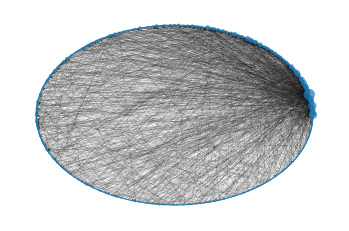

In [72]:
# Visualize the network
import matplotlib.pyplot as plt

# Create circular layout position
pos = nx.circular_layout(G)

# Create size list
sizes = [x[1] for x in G.degree()]

# Draw the network
nx.draw_networkx(G, pos,
                with_labels = False,
                node_size = sizes,
                width = 0.1,
                alpha = 0.7,
                arrowsize = 2,
                linewidths = 0)

# Turn axis off and show
plt.axis('off')
plt.show()

## In-degree Centrality

Centrality is a measure of importance of a node to a network. There are many different types of centrality and each of them has slightly different meaning in Twitter networks. We are first focusing on degree centrality, since its calculation is straightforward and has an intuitive explanation.

For directed networks like Twitter, we need to be careful to distinguish between in-degree and out-degree centrality, especially in retweet networks. In-degree centrality for retweet networks signals users who are getting many retweets.

In [24]:
# Generate in-degree centrality for retweets
in_centrality = nx.in_degree_centrality(G)

# Column names
column_names = ['target_user', 'degree_centrality']

# Store centralities in DataFrame
in_degree = pd.DataFrame(list(in_centrality.items()), columns = column_names)

# Print 5 target users with the highest in-degree centrality
print(in_degree.sort_values('degree_centrality', ascending = False).head())

      target_user  degree_centrality
84        FoxNews           0.055993
38     WhiteHouse           0.031059
1    ScottPresler           0.029746
7      TomiLahren           0.019685
175      HouseGOP           0.017060


## Betweenness Centrality

Betweenness centrality for retweet networks signals users who bridge between different Twitter communities. These communities may be tied together by topic or ideology.

In [25]:
# Generate betweenness centrality for retweets
btw_centrality = nx.betweenness_centrality(G)

# Store centralities in data frames
btw_degree = pd.DataFrame(list(btw_centrality.items()), columns = column_names)

# Print 5 target users with the highest betweenness centrality
print(btw_degree.sort_values('degree_centrality', ascending = False).head())

        target_user  degree_centrality
84          FoxNews           0.000026
29   Public_Citizen           0.000009
206     ChristiChat           0.000005
119      guypbenson           0.000005
362    johncardillo           0.000004


## Most Frequent Words

First we will combine all the words from the retweets; then we will clean them up by removing non-alphabetical words, setting all words to lower case to avoid double counting, and removing stop words. Finally, we will count the unqiue words and observe which ones appeared most frequently in the retweets.

In [67]:
from more_itertools import flatten

# Split words and set to lower case for each retweet
words_in_rt = [rt.lower().split() for rt in retweets['text']]

# Use flatten() to combine words from all retweets
rt_words = list(flatten(words_in_rt))

In [68]:
from nltk.corpus import stopwords

# Remove stop-words
rt_words_nostop = [word for word in rt_words if word not in stopwords.words('english')]

# Remove non-alphabetical text such as numbers, emojis and punctuations
rt_words_clean = [word for word in rt_words_nostop if word.isalpha()]

In [69]:
import collections

# Count each word
count_rt_words = collections.Counter(rt_words_clean)

# Display the top 30 most frequent words
count_rt_words.most_common(30)

[('rt', 2342),
 ('trump', 424),
 ('president', 261),
 ('democrats', 183),
 ('american', 133),
 ('people', 130),
 ('america', 94),
 ('state', 91),
 ('like', 78),
 ('first', 76),
 ('great', 76),
 ('speech', 76),
 ('us', 75),
 ('americans', 74),
 ('stand', 70),
 ('tax', 70),
 ('one', 63),
 ('black', 62),
 ('new', 60),
 ('god', 58),
 ('dems', 57),
 ('union', 56),
 ('every', 51),
 ('tonight', 50),
 ('unemployment', 48),
 ('love', 47),
 ('illegal', 46),
 ('look', 46),
 ('north', 46),
 ('time', 46)]

## Visualization of Most Frequent Words

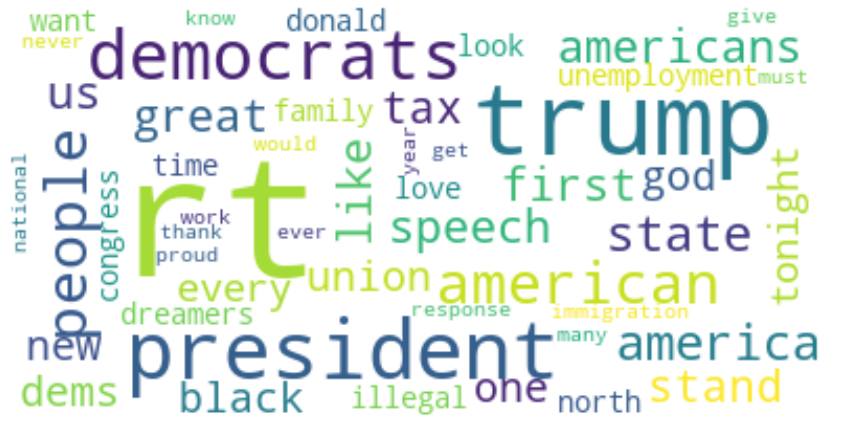

In [65]:
from wordcloud import WordCloud

plt.figure(figsize=(15,15))
wordcloud = WordCloud(background_color="white",
                      max_words=50,
                      relative_scaling=0.5,
                      normalize_plurals=False
                     ).generate_from_frequencies(count_rt_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Conclusion

"FoxNews" was the most influential twitter account in terms of both in-degree centrality (most people retweeted Fox News' tweets) and betweenness centrality (different communities were bridged by FoxNews). Among the retweets, the most frequent words were "President", "Trump", "American"/ "America" (the obvious) and "democrats"/ "dems", "black", "stand", "tax", "illegal", "unemployment", "family". It appeared that most users who retweeted or came across Fox News mentioned about democrats and they cared about race, unemployment, and tax issues against Trump's policies. Recently (April 2020), Trump attacked the conservative channel, accusing the usually uncritical network of being “fed Democratic talking points”, with some observers suggesting his ire may have been caused in part by a string of anti-Trump ads due to run on Fox News this week.

---

source: https://learn.datacamp.com/courses/analyzing-social-media-data-in-python

https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/#:~:text=To%20find%20out%20the%20number,counts%20that%20you%20just%20created.&text=Last%2C%20you%20can%20create%20the,words%2C%20or%20collection%20words).

https://www.theguardian.com/us-news/2020/apr/29/fox-news-trump-democratic-talking-points